In [127]:
import numpy as np
import pandas as pd
import matplotlib as plt
from ucimlrepo import fetch_ucirepo 

In [128]:
! pip install ucimlrepo


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [135]:
def loader_breast_cancer():
        breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

        X = breast_cancer_wisconsin_diagnostic.data.features.to_numpy()
        y = breast_cancer_wisconsin_diagnostic.data.targets.iloc[:, 0].to_numpy()

        y = np.where(y == "M", 1, 0)

        return X, y

def load_landsat():
        statlog_landsat_satellite = fetch_ucirepo(id=146)

        X = statlog_landsat_satellite.data.features.to_numpy()
        y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

        num_classes = len(np.unique(y))
        
        """"
        print("Metadata do dataset:")
        print(statlog_landsat_satellite.metadata)

        print("Informações das variáveis:")
        print(statlog_landsat_satellite.variables)
        """
        
        return X, y, num_classes


Pre-Processamento dos Datasets

In [109]:
def stratified_kfold(X, y, n_splits=5):
    classes = np.unique(y)
    idx_splits = [[] for _ in range(n_splits)]

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        cls_splits = np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            idx_splits[i].extend(cls_splits[i])

    folds = []
    for i in range(n_splits):
        test_idx = np.array(idx_splits[i])
        train_idx = np.array([idx for j, fold in enumerate(idx_splits) if j != i for idx in fold])
        folds.append((train_idx, test_idx))

    return folds

def z_score(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled        



In [132]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_manual(y_true, y_pred, classes=[0, 1], normalize=False, title="Matriz de Confusão"):
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    class_to_index = {cls: i for i, cls in enumerate(classes)}

    # Preencher a matriz
    for true, pred in zip(y_true, y_pred):
        i = class_to_index[true]
        j = class_to_index[pred]
        cm[i, j] += 1

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # Plotar com matplotlib
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Mostrar os números dentro das células
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_xlabel("Predito")
    ax.set_ylabel("Verdadeiro")
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    plt.show()


Implementação Perceptron Clássico

In [114]:
class Perceptron:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.w = None

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d + 1)  

        y_binary = np.where(y == 0, -1, 1)

        for epoch in range(self.epochs):
            errors = 0
            indices = np.arange(n)
            np.random.shuffle(indices)

            for i in indices:
                x_i = np.append(X[i], 1) 
                if y_binary[i] * np.dot(self.w, x_i) <= 0:
                    self.w += self.eta * y_binary[i] * x_i
                    errors += 1

            if errors == 0:
                print(f"Convergência na época {epoch+1}")
                break

    def decision_function(self, X):
        X_bias = np.c_[X, np.ones(X.shape[0])]
        return X_bias @ self.w

    def predict(self, X):
        pred = np.sign(self.decision_function(X))
        return np.where(pred == -1, 0, 1) 

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)



In [69]:
def compute_macro_f1(y_true, y_pred, n_classes=None):
    if n_classes is None:
        n_classes = len(np.unique(np.concatenate([y_true, y_pred])))
    
    f1_scores = []
    
    for i in range(n_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

Convergência na época 453
Convergência na época 109
epochs=500, lr=0.001 -> Acurácia TESTE: 0.9456 ± 0.0114 | Macro-F1: 0.9422 ± 0.0118
Convergência na época 490
Convergência na época 459
Convergência na época 97
epochs=500, lr=0.010 -> Acurácia TESTE: 0.9420 ± 0.0068 | Macro-F1: 0.9383 ± 0.0069
Convergência na época 427
Convergência na época 100
epochs=500, lr=0.100 -> Acurácia TESTE: 0.9438 ± 0.0128 | Macro-F1: 0.9403 ± 0.0132
Convergência na época 536
Convergência na época 574
Convergência na época 452
Convergência na época 95
epochs=1000, lr=0.001 -> Acurácia TESTE: 0.9402 ± 0.0104 | Macro-F1: 0.9364 ± 0.0104
Convergência na época 364
Convergência na época 610
Convergência na época 551
Convergência na época 118
epochs=1000, lr=0.010 -> Acurácia TESTE: 0.9420 ± 0.0089 | Macro-F1: 0.9384 ± 0.0090
Convergência na época 397
Convergência na época 662
Convergência na época 664
Convergência na época 101
epochs=1000, lr=0.100 -> Acurácia TESTE: 0.9403 ± 0.0127 | Macro-F1: 0.9367 ± 0.0129



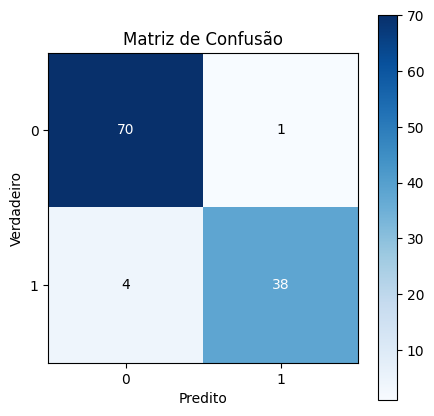

In [ ]:
def run_stratified_cross_validation():
    
    X, y = loader_breast_cancer()
    
    param_grid = {
        "epochs": [500, 1000],
        "learning_rate": [0.001, 0.01, 0.1]
    }
    
    k_folds = 5
    best_result = None
    results = []
    
    folds = stratified_kfold(X, y, n_splits=k_folds)
    
    for epochs in param_grid["epochs"]:
        for learning_rate in param_grid["learning_rate"]:
            
            accuracies_test = []
            f1_scores = []
            
            for fold, (train_idx, test_idx) in enumerate(folds):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                X_train_scaled, X_test_scaled = z_score(X_train, X_test)

                model = Perceptron(epochs=epochs, eta=learning_rate)
                model.fit(X_train_scaled, y_train)
                
                test_accuracy = model.accuracy(X_test_scaled, y_test)
                accuracies_test.append(test_accuracy)

                y_pred = model.predict(X_test_scaled)
                f1 = compute_macro_f1(y_test, y_pred)
                f1_scores.append(f1)
            
            mean_test = np.mean(accuracies_test)
            std_test = np.std(accuracies_test)
            mean_f1 = np.mean(f1_scores)
            std_f1 = np.std(f1_scores)
            
            print(f"epochs={epochs}, lr={learning_rate:.3f} -> "
                  f"Acurácia TESTE: {mean_test:.4f} ± {std_test:.4f} | "
                  f"Macro-F1: {mean_f1:.4f} ± {std_f1:.4f}")
            
            results.append(((epochs, learning_rate), mean_test, std_test, mean_f1, std_f1))
            
            if best_result is None or mean_test > best_result[1]:
                best_result = ((epochs, learning_rate), mean_test, std_test, mean_f1, std_f1)
    
    best_params, best_mean, best_std, best_f1, best_f1_std = best_result
    print(f"\nMelhor configuração: epochs={best_params[0]}, lr={best_params[1]} "
          f"-> Acurácia {best_mean:.4f} ± {best_std:.4f} | "
          f"Macro-F1 {best_f1:.4f} ± {best_f1_std:.4f}")


    last_train_idx, last_test_idx = folds[-1]
    X_train, X_test = X[last_train_idx], X[last_test_idx]
    y_train, y_test = y[last_train_idx], y[last_test_idx]
    X_train_scaled, X_test_scaled = z_score(X_train, X_test)

    best_model = Perceptron(epochs=best_params[0], eta=best_params[1])
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)

    plot_confusion_matrix_manual(y_test, y_pred, classes=[0, 1], normalize=False)

    return best_result

if __name__ == "__main__":
    best_params = run_stratified_cross_validation()

Implementação do z

In [136]:
class PerceptronOvR:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.classifiers = {}  

    def fit(self, X, y, num_classes):
        for c in range(num_classes):
            print(f"Treinando classe {c} vs resto...")
            y_binary = np.where(y == c, 1, 0)  # c como +1, resto como 0
            p = Perceptron(epochs=self.epochs, eta=self.eta)
            p.fit(X, y_binary)
            self.classifiers[c] = p

    def decision_function(self, X):
        # retorna matriz de scores [n_samples, n_classes]
        scores = np.column_stack([self.classifiers[c].decision_function(X) 
                                  for c in self.classifiers])
        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        return np.argmax(scores, axis=1)  # escolhe a classe com maior score

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [ ]:
def cross_val_ovr(X, y, num_classes, epochs=100, eta=0.01, n_splits=5):
    folds = stratified_kfold(X, y, n_splits)
    acc_list = []

    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Padronização
        X_train_scaled, X_test_scaled = z_score(X_train, X_test)

        # Treino OvR
        model = PerceptronOvR(epochs=epochs, eta=eta)
        model.fit(X_train_scaled, y_train, num_classes)

        acc = model.accuracy(X_test_scaled, y_test)
        print(f"Dobra {fold_idx+1}: acurácia = {acc:.4f}")
        acc_list.append(acc)

    print(f"Acurácia média: {np.mean(acc_list):.4f}")
    return np.mean(acc_list)

# === Uso com Landsat ===
if __name__ == "__main__":
    from sklearn.datasets import fetch_openml
    dataset = fetch_openml(data_id=146, as_frame=True)
    X = dataset.data.to_numpy()
    y = dataset.target.to_numpy().astype(int)
    num_classes = len(np.unique(y))

    cross_val_ovr(X, y, num_classes, epochs=200, eta=0.01, n_splits=5)

ValueError: invalid literal for int() with base 10: 'g'

In [141]:
import numpy as np
import pandas as pd

# === Função para baixar o dataset Landsat do OpenML ===
def load_landsat():
        statlog_landsat_satellite = fetch_ucirepo(id=146)

        X = statlog_landsat_satellite.data.features.to_numpy()
        y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

        num_classes = len(np.unique(y))
        
        """"
        print("Metadata do dataset:")
        print(statlog_landsat_satellite.metadata)

        print("Informações das variáveis:")
        print(statlog_landsat_satellite.variables)
        """
        
        return X, y, num_classes

def stratified_kfold(X, y, n_splits=5):
    classes = np.unique(y)
    idx_splits = [[] for _ in range(n_splits)]

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        cls_splits = np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            idx_splits[i].extend(cls_splits[i])

    folds = []
    for i in range(n_splits):
        test_idx = np.array(idx_splits[i])
        train_idx = np.array([idx for j, fold in enumerate(idx_splits) if j != i for idx in fold])
        folds.append((train_idx, test_idx))

    return folds

def z_score(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

# === Perceptron binário ===
class Perceptron:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.w = None

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d + 1)
        # assumimos que y já vem como -1 e 1
        for epoch in range(self.epochs):
            errors = 0
            indices = np.arange(n)
            np.random.shuffle(indices)
            for i in indices:
                x_i = np.append(X[i], 1)
                if y[i] * np.dot(self.w, x_i) <= 0:
                    self.w += self.eta * y[i] * x_i
                    errors += 1
            if errors == 0:
                break


    def decision_function(self, X):
        X_bias = np.c_[X, np.ones(X.shape[0])]
        return X_bias @ self.w

    def predict(self, X):
        pred = np.sign(self.decision_function(X))
        return np.where(pred == -1, 0, 1)

# === OvR Multiclasse ===
class PerceptronOvR:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.classifiers = {}

    def fit(self, X, y, num_classes):
        for c in range(num_classes):
            print(f"Treinando classe {c} vs resto...")
            y_binary = np.where(y == c, 1, -1)  # ← Agora está correto
            p = Perceptron(epochs=self.epochs, eta=self.eta)
            p.fit(X, y_binary)
            self.classifiers[c] = p


    def decision_function(self, X):
        scores = np.column_stack([self.classifiers[c].decision_function(X) 
                                  for c in self.classifiers])
        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        return np.argmax(scores, axis=1)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# === Validação cruzada OvR ===
def cross_val_ovr(X, y, num_classes, epochs=100, eta=0.01, n_splits=5):
    folds = stratified_kfold(X, y, n_splits)
    acc_list = []

    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Padronização
        X_train_scaled, X_test_scaled = z_score(X_train, X_test)

        # Treino OvR
        model = PerceptronOvR(epochs=epochs, eta=eta)
        model.fit(X_train_scaled, y_train, num_classes)

        acc = model.accuracy(X_test_scaled, y_test)
        print(f"Dobra {fold_idx+1}: acurácia = {acc:.4f}")
        acc_list.append(acc)

    print(f"Acurácia média: {np.mean(acc_list):.4f}")
    return np.mean(acc_list)

# === Uso ===
if __name__ == "__main__":
    X, y, num_classes = load_landsat()
    cross_val_ovr(X, y, num_classes, epochs=200, eta=0.01, n_splits=5)


Treinando classe 0 vs resto...
Treinando classe 1 vs resto...
Treinando classe 2 vs resto...
Treinando classe 3 vs resto...
Treinando classe 4 vs resto...
Treinando classe 5 vs resto...
Dobra 1: acurácia = 0.6008
Treinando classe 0 vs resto...
Treinando classe 1 vs resto...
Treinando classe 2 vs resto...
Treinando classe 3 vs resto...
Treinando classe 4 vs resto...
Treinando classe 5 vs resto...
Dobra 2: acurácia = 0.6362
Treinando classe 0 vs resto...
Treinando classe 1 vs resto...
Treinando classe 2 vs resto...
Treinando classe 3 vs resto...
Treinando classe 4 vs resto...
Treinando classe 5 vs resto...
Dobra 3: acurácia = 0.6211
Treinando classe 0 vs resto...
Treinando classe 1 vs resto...
Treinando classe 2 vs resto...
Treinando classe 3 vs resto...
Treinando classe 4 vs resto...
Treinando classe 5 vs resto...
Dobra 4: acurácia = 0.6192
Treinando classe 0 vs resto...
Treinando classe 1 vs resto...
Treinando classe 2 vs resto...
Treinando classe 3 vs resto...
Treinando classe 4 vs re

In [143]:
import numpy as np
from ucimlrepo import fetch_ucirepo # Biblioteca que parece estar sendo usada para load_landsat

# --- Código das Funções e Classes que você já possui (Omissas por brevidade) ---

# === Função para baixar o dataset Landsat do OpenML ===
# IMPORTANTE: Você precisa garantir que esta função (e as importações necessárias) funcione em seu ambiente.
def load_landsat():
        statlog_landsat_satellite = fetch_ucirepo(id=146)

        X = statlog_landsat_satellite.data.features.to_numpy()
        y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

        # O dataset Landsat no UCI tem as classes rotuladas de 1 a 7.
        # Para que as classes 0 a 5 no seu código funcionem, faremos a conversão.
        # A classe '7' é a 'background/miscellaneous', que muitas vezes é removida ou ignorada.
        # Assumindo que você está usando as classes 1 a 6 (para ter 6 classes, como no seu output)
        # e as mapeando para 0 a 5:
        unique_y = np.unique(y)
        if len(unique_y) == 7: # Se a classe 7 estiver presente
            # Se a classe 7 (geralmente background) estiver presente, vamos removê-la para replicar o cenário de 6 classes (0 a 5)
            # ou assumir que as classes usadas são de 1 a 6 (o Landsat tem 7 classes, 1 a 7).
            # Para o seu código ter 6 classes (0 a 5), vamos mapear as classes 1-6 para 0-5.
            y_clean = y[y != 7]
            X_clean = X[y != 7]
            # Mapeia 1->0, 2->1, ..., 6->5
            y_mapped = y_clean - 1
            X, y = X_clean, y_mapped
        elif len(unique_y) == 6 and np.min(unique_y) == 1:
            # Mapeia 1->0, 2->1, ..., 6->5
            y = y - 1
        
        num_classes = len(np.unique(y))
        
        return X, y, num_classes

def stratified_kfold(X, y, n_splits=5):
    classes = np.unique(y)
    idx_splits = [[] for _ in range(n_splits)]

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        cls_splits = np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            idx_splits[i].extend(cls_splits[i])

    folds = []
    for i in range(n_splits):
        test_idx = np.array(idx_splits[i])
        train_idx = np.array([idx for j, fold in enumerate(idx_splits) if j != i for idx in fold])
        folds.append((train_idx, test_idx))

    return folds

def z_score(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

# === Perceptron binário ===
class Perceptron:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.w = None

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d + 1)
        for epoch in range(self.epochs):
            errors = 0
            indices = np.arange(n)
            np.random.shuffle(indices)
            for i in indices:
                x_i = np.append(X[i], 1)
                if y[i] * np.dot(self.w, x_i) <= 0:
                    self.w += self.eta * y[i] * x_i
                    errors += 1
            if errors == 0:
                break


    def decision_function(self, X):
        X_bias = np.c_[X, np.ones(X.shape[0])]
        return X_bias @ self.w

    def predict(self, X):
        pred = np.sign(self.decision_function(X))
        return np.where(pred == -1, 0, 1)

# === OvR Multiclasse ===
class PerceptronOvR:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.classifiers = {}

    def fit(self, X, y, num_classes):
        for c in range(num_classes):
            # print(f"Treinando classe {c} vs resto...") # Desativado para o grid search
            y_binary = np.where(y == c, 1, -1)
            p = Perceptron(epochs=self.epochs, eta=self.eta)
            p.fit(X, y_binary)
            self.classifiers[c] = p


    def decision_function(self, X):
        scores = np.column_stack([self.classifiers[c].decision_function(X) 
                                  for c in self.classifiers])
        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        return np.argmax(scores, axis=1)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# === Validação cruzada OvR (função original) ===
def cross_val_ovr(X, y, num_classes, epochs=100, eta=0.01, n_splits=5):
    folds = stratified_kfold(X, y, n_splits)
    acc_list = []

    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Padronização
        X_train_scaled, X_test_scaled = z_score(X_train, X_test)

        # Treino OvR
        model = PerceptronOvR(epochs=epochs, eta=eta)
        model.fit(X_train_scaled, y_train, num_classes)

        acc = model.accuracy(X_test_scaled, y_test)
        # print(f"Dobra {fold_idx+1}: acurácia = {acc:.4f}") # Desativado para o grid search
        acc_list.append(acc)

    # print(f"Acurácia média: {np.mean(acc_list):.4f}") # Desativado para o grid search
    return np.mean(acc_list)

# === Implementação do Grid Search ===
def grid_search_perceptron_ovr(X, y, num_classes, n_splits=5):
    
    # DEFINIÇÃO DA GRADE DE PARÂMETROS
    # Experimente mais valores se tiver tempo.
    param_grid = {
        'eta': [ 0.01, 0.1,],
        'epochs': [ 200, 500, 1000] 
    }
    
    best_acc = 0.0
    best_params = {}
    results = []

    print("--- Iniciando Grid Search ---")
    
    # Itera sobre todas as combinações de hiperparâmetros
    for eta in param_grid['eta']:
        for epochs in param_grid['epochs']:
            
            print(f"Testando: eta={eta}, epochs={epochs}...")
            
            # Executa a validação cruzada para a combinação atual
            mean_acc = cross_val_ovr(X, y, num_classes, epochs=epochs, eta=eta, n_splits=n_splits)
            
            print(f"  -> Acurácia Média: {mean_acc:.4f}\n")
            
            results.append({
                'eta': eta,
                'epochs': epochs,
                'accuracy': mean_acc
            })
            
            # Atualiza o melhor modelo encontrado
            if mean_acc > best_acc:
                best_acc = mean_acc
                best_params = {'eta': eta, 'epochs': epochs}

    print("--- Fim do Grid Search ---")
    print(f"Melhor Acurácia Encontrada: {best_acc:.4f}")
    print(f"Melhores Parâmetros: {best_params}")
    return results, best_params

# === Uso ===
if __name__ == "__main__":
    X, y, num_classes = load_landsat()
    grid_search_perceptron_ovr(X, y, num_classes, n_splits=5)

--- Iniciando Grid Search ---
Testando: eta=0.01, epochs=200...
  -> Acurácia Média: 0.6095

Testando: eta=0.01, epochs=500...
  -> Acurácia Média: 0.6010

Testando: eta=0.01, epochs=1000...


KeyboardInterrupt: 

In [151]:
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# ==============================================================================
# === FUNÇÃO DE CARREGAMENTO DE DADOS (MANTIDA) ===
# ==============================================================================
def load_landsat():
    """
    Carrega e pré-processa o dataset Landsat.
    Remove a classe 7 (background) e mapeia as classes de 1-6 para 0-5.
    """
    statlog_landsat_satellite = fetch_ucirepo(id=146)

    # Convertendo para numpy e extraindo a primeira coluna dos targets
    X = statlog_landsat_satellite.data.features.to_numpy()
    y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

    unique_y = np.unique(y)
    
    # Pré-processamento conforme a lógica original: 
    # Mapear 1-6 para 0-5 e remover a classe 7 se presente
    if 7 in unique_y: 
        # Remove classe '7' (background) e mapeia 1-6 para 0-5
        y_clean = y[y != 7]
        X_clean = X[y != 7]
        y_mapped = y_clean - 1
        X, y = X_clean, y_mapped
    elif np.min(unique_y) == 1:
        # Mapeia 1-6 para 0-5
        y = y - 1
    
    num_classes = len(np.unique(y))
    
    print(f"Dataset Landsat carregado. Formato: X={X.shape}, y={y.shape}. Classes: {num_classes}")
    return X, y, num_classes

# ==============================================================================
# === GRID SEARCH COM SCIKIT-LEARN (NORMALIZAÇÃO E CLASSIFICADOR) ===
# ==============================================================================
def grid_search_perceptron_ovr_sklearn(X, y, num_classes, n_splits=5):
    
    # 1. Cria um Pipeline: Normalização (MinMaxScaler) + Classificador (Perceptron)
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),      # Normalização Min-Max
        ('clf', Perceptron(shuffle=True, 
                           random_state=42
                          )) 
    ])
    
    # 2. Define a Grade de Parâmetros para o Grid Search (ATUALIZADA)
    # Aumentando o leque de 'eta0' (taxa de aprendizado) e 'max_iter' (épocas)
    param_grid = {
        'clf__eta0': [0.001, 0.01, 0.05, 0.1], # Novos valores: 0.001 e 0.05
        'clf__max_iter': [500, 1000, 2000, 5000], # Novos valores: 2000 e 5000
        'clf__tol': [None] 
    }
    
    # 3. Configura a Validação Cruzada Estratificada
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # 4. Configura o Grid Search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1 # Usa todos os núcleos da CPU
    )
    
    print("--- Iniciando Grid Search com scikit-learn (MinMaxScaler + Perceptron OvR) ---")
    print(f"Total de combinações (folds * params): {n_splits} * {len(param_grid['clf__eta0']) * len(param_grid['clf__max_iter'])} = {n_splits * len(param_grid['clf__eta0']) * len(param_grid['clf__max_iter'])} fits")
    
    # 5. Executa o Grid Search
    grid_search.fit(X, y)
    
    print("\n--- Fim do Grid Search ---")
    print(f"Melhor Acurácia Média Encontrada (CV): {grid_search.best_score_:.4f}")
    
    best_params_sklearn = grid_search.best_params_
    
    # Convertendo os parâmetros para a nomenclatura original (eta, epochs)
    best_params_display = {
        'eta': best_params_sklearn['clf__eta0'],
        'epochs': best_params_sklearn['clf__max_iter']
    }
    print(f"Melhores Parâmetros (eta/epochs): {best_params_display}")
    
    # Exibe todos os resultados
    results = []
    for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        results.append({
            'eta': params['clf__eta0'],
            'epochs': params['clf__max_iter'],
            'accuracy': mean_score
        })
    
    return results, best_params_display, grid_search.best_estimator_

# ==============================================================================
# === EXECUÇÃO PRINCIPAL ===
# ==============================================================================
if __name__ == "__main__":
    # Carrega os dados
    X, y, num_classes = load_landsat()
    
    # Executa o Grid Search com o Scikit-learn
    results, best_params, best_model = grid_search_perceptron_ovr_sklearn(X, y, num_classes, n_splits=5)
    
    print("\n\n--- Resumo de Todos os Resultados ---")
    # Ordenar por acurácia para melhor visualização
    results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)
    
    for res in results_sorted:
        print(f"eta={res['eta']:.3f}, epochs={res['epochs']:4d} -> Acurácia: {res['accuracy']:.4f}")

    # Acurácia final no dataset completo (apenas para referência)
    y_pred = best_model.predict(X)
    final_accuracy = accuracy_score(y, y_pred)
    print(f"\nMelhor modelo (após ajuste): Acurácia no dataset completo: {final_accuracy:.4f}")

Dataset Landsat carregado. Formato: X=(4927, 36), y=(4927,). Classes: 5
--- Iniciando Grid Search com scikit-learn (MinMaxScaler + Perceptron OvR) ---
Total de combinações (folds * params): 5 * 16 = 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- Fim do Grid Search ---
Melhor Acurácia Média Encontrada (CV): 0.8587
Melhores Parâmetros (eta/epochs): {'eta': 0.001, 'epochs': 500}


--- Resumo de Todos os Resultados ---
eta=0.001, epochs= 500 -> Acurácia: 0.8587
eta=0.010, epochs= 500 -> Acurácia: 0.8587
eta=0.050, epochs= 500 -> Acurácia: 0.8587
eta=0.100, epochs= 500 -> Acurácia: 0.8587
eta=0.001, epochs=5000 -> Acurácia: 0.8539
eta=0.010, epochs=5000 -> Acurácia: 0.8539
eta=0.050, epochs=5000 -> Acurácia: 0.8539
eta=0.100, epochs=5000 -> Acurácia: 0.8539
eta=0.001, epochs=1000 -> Acurácia: 0.8498
eta=0.010, epochs=1000 -> Acurácia: 0.8498
eta=0.050, epochs=1000 -> Acurácia: 0.8498
eta=0.100, epochs=1000 -> Acurácia: 0.8498
eta=0.001, epochs=2000 -> Acurácia: 0.

In [153]:
import numpy as np
from ucimlrepo import fetch_ucirepo

# =========================================================
# === PERCEPTRON BINÁRIO PERSONALIZADO ===
# =========================================================
class PerceptronCustom:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.w = None

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d + 1)  # inclui bias
        y_binary = np.where(y == 0, -1, 1)  # binário

        for epoch in range(self.epochs):
            errors = 0
            indices = np.arange(n)
            np.random.shuffle(indices)

            for i in indices:
                x_i = np.append(X[i], 1)
                if y_binary[i] * np.dot(self.w, x_i) <= 0:
                    self.w += self.eta * y_binary[i] * x_i
                    errors += 1

            if errors == 0:
                break

    def decision_function(self, X):
        X_bias = np.c_[X, np.ones(X.shape[0])]
        return X_bias @ self.w

    def predict(self, X):
        pred = np.sign(self.decision_function(X))
        return np.where(pred == -1, 0, 1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)


# =========================================================
# === FUNÇÃO PRÓPRIA DE MIN-MAX SCALING ===
# =========================================================
def min_max_scale(X):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    return (X - X_min) / (X_max - X_min + 1e-8)


# =========================================================
# === STRATIFIED K-FOLD PRÓPRIO ===
# =========================================================
def stratified_kfold(X, y, n_splits=5):
    classes = np.unique(y)
    idx_splits = [[] for _ in range(n_splits)]

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        cls_splits = np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            idx_splits[i].extend(cls_splits[i])

    folds = []
    for i in range(n_splits):
        test_idx = np.array(idx_splits[i])
        train_idx = np.array([idx for j, fold in enumerate(idx_splits) if j != i for idx in fold])
        folds.append((train_idx, test_idx))

    return folds


# =========================================================
# === CARREGAMENTO DO DATASET LANDSAT ===
# =========================================================
def load_landsat():
    statlog_landsat_satellite = fetch_ucirepo(id=146)
    X = statlog_landsat_satellite.data.features.to_numpy()
    y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

    if 7 in y:
        mask = y != 7
        X, y = X[mask], y[mask] - 1
    elif np.min(y) == 1:
        y = y - 1

    num_classes = len(np.unique(y))
    return X, y, num_classes


# =========================================================
# === GRID SEARCH MANUAL COM PERCEPTRON PERSONALIZADO E OVR ===
# =========================================================
def grid_search_perceptron_ovr_custom(X, y, num_classes, n_splits=5,
                                      etas=[0.001],
                                      epochs_list=[600]):
    X_scaled = min_max_scale(X)
    folds = stratified_kfold(X_scaled, y, n_splits=n_splits)
    results = []

    for eta in etas:
        for epochs in epochs_list:
            fold_accuracies = []

            for train_idx, test_idx in folds:
                X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # Treinar OvR
                preds = np.zeros((len(y_test), num_classes))
                for c in range(num_classes):
                    y_binary = np.where(y_train == c, 1, 0)
                    clf = PerceptronCustom(epochs=epochs, eta=eta)
                    clf.fit(X_train, y_binary)
                    preds[:, c] = clf.decision_function(X_test)

                y_pred = np.argmax(preds, axis=1)
                fold_accuracies.append(np.mean(y_pred == y_test))

            mean_acc = np.mean(fold_accuracies)
            results.append({'eta': eta, 'epochs': epochs, 'accuracy': mean_acc})
            print(f"eta={eta}, epochs={epochs} -> CV Accuracy: {mean_acc:.4f}")

    best = max(results, key=lambda x: x['accuracy'])
    print("\nMelhor combinação:", best)
    return results, best


# =========================================================
# === EXECUÇÃO PRINCIPAL ===
# =========================================================
if __name__ == "__main__":
    X, y, num_classes = load_landsat()
    results, best = grid_search_perceptron_ovr_custom(X, y, num_classes)


eta=0.001, epochs=600 -> CV Accuracy: 0.8614

Melhor combinação: {'eta': 0.001, 'epochs': 600, 'accuracy': np.float64(0.8613598069770709)}


eta=0.001, epochs=600 -> CV Accuracy: 0.8166, Macro-F1: 0.7289
eta=0.01, epochs=600 -> CV Accuracy: 0.8028, Macro-F1: 0.7031

Melhor combinação: {'eta': 0.001, 'epochs': 600, 'accuracy': np.float64(0.8166295626574117), 'macro_f1': np.float64(0.728936987146603)}


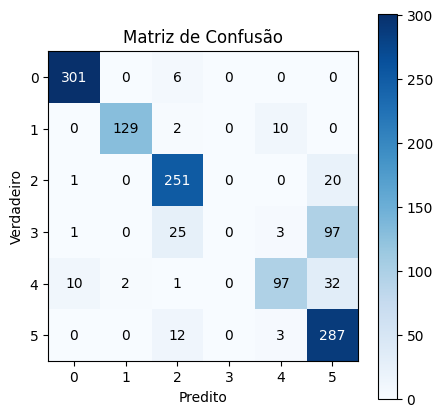

In [ ]:
import numpy as np
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

# =========================================================
# === PERCEPTRON BINÁRIO PERSONALIZADO ===
# =========================================================
class PerceptronCustom:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.w = None

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d + 1)  # inclui bias
        y_binary = np.where(y == 0, -1, 1)  # binário

        for epoch in range(self.epochs):
            errors = 0
            indices = np.arange(n)
            np.random.shuffle(indices)

            for i in indices:
                x_i = np.append(X[i], 1)
                if y_binary[i] * np.dot(self.w, x_i) <= 0:
                    self.w += self.eta * y_binary[i] * x_i
                    errors += 1

            if errors == 0:
                break

    def decision_function(self, X):
        X_bias = np.c_[X, np.ones(X.shape[0])]
        return X_bias @ self.w

    def predict(self, X):
        pred = np.sign(self.decision_function(X))
        return np.where(pred == -1, 0, 1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)


# =========================================================
# === FUNÇÃO PRÓPRIA DE MIN-MAX SCALING ===
# =========================================================
def min_max_scale(X):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    return (X - X_min) / (X_max - X_min + 1e-8)


# =========================================================
# === STRATIFIED K-FOLD PRÓPRIO ===
# =========================================================
def stratified_kfold(X, y, n_splits=5):
    classes = np.unique(y)
    idx_splits = [[] for _ in range(n_splits)]

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        cls_splits = np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            idx_splits[i].extend(cls_splits[i])

    folds = []
    for i in range(n_splits):
        test_idx = np.array(idx_splits[i])
        train_idx = np.array([idx for j, fold in enumerate(idx_splits) if j != i for idx in fold])
        folds.append((train_idx, test_idx))

    return folds


# =========================================================
# === CARREGAMENTO DO DATASET LANDSAT ===
# =========================================================
def load_landsat():
    statlog_landsat_satellite = fetch_ucirepo(id=146)
    X = statlog_landsat_satellite.data.features.to_numpy()
    y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

    # Define o mapeamento para as 6 classes presentes: {1, 2, 3, 4, 5, 7} -> {0, 1, 2, 3, 4, 5}
    mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
    
    # Cria uma máscara para incluir apenas as classes que queremos mapear (removendo a classe 6, que é ausente)
    mask = np.isin(y, list(mapping.keys()))
    X = X[mask]
    y = y[mask]

    # Aplica o mapeamento para garantir rótulos contínuos de 0 a 5
    y = np.array([mapping[label] for label in y])

    num_classes = len(np.unique(y)) # Agora deve retornar 6
    return X, y, num_classes


# =========================================================
# === MÉTRICA MACRO F1 ===
# =========================================================
def compute_macro_f1(y_true, y_pred, n_classes=None):
    if n_classes is None:
        n_classes = len(np.unique(np.concatenate([y_true, y_pred])))
    
    f1_scores = []
    for i in range(n_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return np.mean(f1_scores)


# =========================================================
# === MATRIZ DE CONFUSÃO MANUAL ===
# =========================================================
def plot_confusion_matrix_manual(y_true, y_pred, classes=[0, 1], normalize=False, title="Matriz de Confusão"):
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    class_to_index = {cls: i for i, cls in enumerate(classes)}

    for true, pred in zip(y_true, y_pred):
        i = class_to_index[true]
        j = class_to_index[pred]
        cm[i, j] += 1

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_xlabel("Predito")
    ax.set_ylabel("Verdadeiro")
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    plt.show()


# =========================================================
# === GRID SEARCH MANUAL COM PERCEPTRON PERSONALIZADO E OVR ===
# =========================================================
def grid_search_perceptron_ovr_custom(X, y, num_classes, n_splits=5,
                                      etas=[0.001],
                                      epochs_list=[600]):
    X_scaled = min_max_scale(X)
    folds = stratified_kfold(X_scaled, y, n_splits=n_splits)
    results = []

    for eta in etas:
        for epochs in epochs_list:
            fold_accuracies = []
            fold_f1s = []

            for train_idx, test_idx in folds:
                X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                preds = np.zeros((len(y_test), num_classes))
                for c in range(num_classes):
                    y_binary = np.where(y_train == c, 1, 0)
                    clf = PerceptronCustom(epochs=epochs, eta=eta)
                    clf.fit(X_train, y_binary)
                    preds[:, c] = clf.decision_function(X_test)

                y_pred = np.argmax(preds, axis=1)
                acc = np.mean(y_pred == y_test)
                f1 = compute_macro_f1(y_test, y_pred, n_classes=num_classes)

                fold_accuracies.append(acc)
                fold_f1s.append(f1)

            mean_acc = np.mean(fold_accuracies)
            mean_f1 = np.mean(fold_f1s)
            results.append({'eta': eta, 'epochs': epochs, 'accuracy': mean_acc, 'macro_f1': mean_f1})
            print(f"eta={eta}, epochs={epochs} -> CV Accuracy: {mean_acc:.4f}, Macro-F1: {mean_f1:.4f}")

    best = max(results, key=lambda x: x['accuracy'])
    print("\nMelhor combinação:", best)
    return results, best


# =========================================================
# === EXECUÇÃO PRINCIPAL ===
# =========================================================
if __name__ == "__main__":
    X, y, num_classes = load_landsat()
    results, best = grid_search_perceptron_ovr_custom(X, y, num_classes)

    X_scaled = min_max_scale(X)
    folds = stratified_kfold(X_scaled, y, n_splits=5)
    train_idx, test_idx = folds[0]
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    preds = np.zeros((len(y_test), num_classes))
    for c in range(num_classes):
        y_binary = np.where(y_train == c, 1, 0)
        clf = PerceptronCustom(epochs=best['epochs'], eta=best['eta'])
        clf.fit(X_train, y_binary)
        preds[:, c] = clf.decision_function(X_test)

    y_pred = np.argmax(preds, axis=1)
    plot_confusion_matrix_manual(y_test, y_pred, classes=list(range(num_classes)), normalize=False)


In [166]:
import numpy as np
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

# =========================================================
# === PERCEPTRON BINÁRIO PERSONALIZADO ===
# =========================================================
class PerceptronCustom:
    def __init__(self, epochs=100, eta=0.1):
        self.epochs = epochs
        self.eta = eta
        self.w = None

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d + 1)  # inclui bias
        y_binary = np.where(y == 0, -1, 1)  # binário

        for epoch in range(self.epochs):
            errors = 0
            indices = np.arange(n)
            np.random.shuffle(indices)

            for i in indices:
                x_i = np.append(X[i], 1)
                if y_binary[i] * np.dot(self.w, x_i) <= 0:
                    self.w += self.eta * y_binary[i] * x_i
                    errors += 1

            if errors == 0:
                break

    def decision_function(self, X):
        X_bias = np.c_[X, np.ones(X.shape[0])]
        return X_bias @ self.w

    def predict(self, X):
        pred = np.sign(self.decision_function(X))
        return np.where(pred == -1, 0, 1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)


# =========================================================
# === FUNÇÃO PRÓPRIA DE MIN-MAX SCALING POR FOLD ===
# =========================================================
def min_max_scale_train_test(X_train, X_test):
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    denom = (X_max - X_min) + 1e-8
    X_train_s = (X_train - X_min) / denom
    X_test_s = (X_test - X_min) / denom
    return X_train_s, X_test_s


# =========================================================
# === STRATIFIED K-FOLD PRÓPRIO ===
# =========================================================
def stratified_kfold(X, y, n_splits=5):
    classes = np.unique(y)
    idx_splits = [[] for _ in range(n_splits)]

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        cls_splits = np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            idx_splits[i].extend(cls_splits[i])

    folds = []
    for i in range(n_splits):
        test_idx = np.array(idx_splits[i])
        train_idx = np.array([idx for j, fold in enumerate(idx_splits) if j != i for idx in fold])
        folds.append((train_idx, test_idx))

    return folds


# =========================================================
# === CARREGAMENTO DO DATASET LANDSAT ===
# =========================================================

def load_lansat():
    statlog_landsat_satellite = fetch_ucirepo(id=146)
    X = statlog_landsat_satellite.data.features.to_numpy()
    y = statlog_landsat_satellite.data.targets.iloc[:, 0].to_numpy()

    # Pega todas as classes originais
    classes = np.unique(y)
    num_classes = len(classes)

    return X, y, num_classes, classes


# =========================================================
# === MÉTRICA MACRO F1 ===
# =========================================================
def compute_macro_f1(y_true, y_pred, n_classes=None):
    if n_classes is None:
        n_classes = len(np.unique(np.concatenate([y_true, y_pred])))
    
    f1_scores = []
    for i in range(n_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return np.mean(f1_scores)


# =========================================================
# === MATRIZ DE CONFUSÃO MANUAL ===
# =========================================================
def plot_confusion_matrix_manual(y_true, y_pred, classes=[0, 1], normalize=False, title="Matriz de Confusão"):
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    class_to_index = {cls: i for i, cls in enumerate(classes)}

    for true, pred in zip(y_true, y_pred):
        i = class_to_index[true]
        j = class_to_index[pred]
        cm[i, j] += 1

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_xlabel("Predito")
    ax.set_ylabel("Verdadeiro")
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    plt.show()


# =========================================================
# === GRID SEARCH MANUAL COM PERCEPTRON PERSONALIZADO E OVR ===
# =========================================================
def grid_search_perceptron_ovr_custom(X, y, num_classes, n_splits=5,
                                      etas=[0.001],
                                      epochs_list=[200]):
    folds = stratified_kfold(X, y, n_splits=n_splits)
    results = []

    for eta in etas:
        for epochs in epochs_list:
            fold_accuracies = []
            fold_f1s = []

            for train_idx, test_idx in folds:
                X_train_raw, X_test_raw = X[train_idx], X[test_idx]
                X_train, X_test = min_max_scale_train_test(X_train_raw, X_test_raw)
                y_train, y_test = y[train_idx], y[test_idx]

                # Treinar OvR
                preds = np.zeros((len(y_test), num_classes))
                for c in range(num_classes):
                    y_binary = np.where(y_train == c, 1, 0)
                    clf = PerceptronCustom(epochs=epochs, eta=eta)
                    clf.fit(X_train, y_binary)
                    preds[:, c] = clf.decision_function(X_test)

                y_pred = np.argmax(preds, axis=1)
                acc = np.mean(y_pred == y_test)
                f1 = compute_macro_f1(y_test, y_pred, n_classes=num_classes)

                fold_accuracies.append(acc)
                fold_f1s.append(f1)

            mean_acc = np.mean(fold_accuracies)
            mean_f1 = np.mean(fold_f1s)
            results.append({'eta': eta, 'epochs': epochs, 'accuracy': mean_acc, 'macro_f1': mean_f1})
            print(f"eta={eta}, epochs={epochs} -> CV Accuracy: {mean_acc:.4f}, Macro-F1: {mean_f1:.4f}")

    best = max(results, key=lambda x: x['accuracy'])
    print("\nMelhor combinação:", best)
    return results, best


# =========================================================
# === EXECUÇÃO PRINCIPAL ===
# =========================================================
if __name__ == "__main__":
    X, y, num_classes = load_landsat()
    results, best = grid_search_perceptron_ovr_custom(X, y, num_classes)

    folds = stratified_kfold(X, y, n_splits=5)
    train_idx, test_idx = folds[0]
    X_train_raw, X_test_raw = X[train_idx], X[test_idx]
    X_train, X_test = min_max_scale_train_test(X_train_raw, X_test_raw)
    y_train, y_test = y[train_idx], y[test_idx]

    preds = np.zeros((len(y_test), num_classes))
    for c in range(num_classes):
        y_binary = np.where(y_train == c, 1, 0)
        clf = PerceptronCustom(epochs=best['epochs'], eta=best['eta'])
        clf.fit(X_train, y_binary)
        preds[:, c] = clf.decision_function(X_test)

    y_pred = np.argmax(preds, axis=1)
    plot_confusion_matrix_manual(y_test, y_pred, classes=list(range(num_classes)), normalize=False)


KeyboardInterrupt: 